<a href="https://colab.research.google.com/github/titusss/Collective-Dreams_Fluid-Interfaces/blob/master/Experiments/Collective_Dream_BERTopic_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tutorial** - Topic Modeling with BERTopic
(last updated 08-06-2021)

In this tutorial we will be exploring how to use BERTopic to create topics from the well-known 20Newsgroups dataset. The most frequent use-cases and methods are discussed together with important parameters to keep a look out for. 


## BERTopic
BERTopic is a topic modeling technique that leverages 🤗 transformers and a custom class-based TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions. 

<br>

<img src="https://raw.githubusercontent.com/MaartenGr/BERTopic/master/images/logo.png" width="40%">

# Enabling the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

[Reference](https://colab.research.google.com/notebooks/gpu.ipynb)

# **Installing BERTopic**

We start by installing BERTopic from PyPi:

In [1]:
%%capture
!pip install bertopic

## Restart the Notebook
After installing BERTopic, some packages that were already loaded were updated and in order to correctly use them, we should now restart the notebook.

From the Menu:

Runtime → Restart Runtime

In [2]:
!nvidia-smi

Sat Dec 18 00:26:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data
For this example, we use the popular 20 Newsgroups dataset which contains roughly 18000 newsgroups posts

Note: We're not using this for the dreams. We have our own dataset which we're loading from google drive below.

In [3]:
from sklearn.datasets import fetch_20newsgroups
docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

These are custom cells to load the dream dataset from CSV to Pandas DF and then to Python array.

In [4]:
from google.colab import drive

drive.mount('content')



Mounted at content


In [5]:
!pip install pandas
import pandas as pd
df = pd.read_csv('/content/content/MyDrive/2112_Collective_Dream_Fluid_Interfaces/Datasets/Edited/dreams_dataset.tsv', sep='\t')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,10,11,12,13,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Remove 100 most common words in english

In [6]:
most_common_words = ["the", "be", "to", "of", "and", "a", "in", "that", "have", "i", "it", "for", "not", "on", "with", "he", "as", "you", "do", "at", "this", "but", "his", "by", "from", "they", "we", "say", "her", "she", "or", "an", "will", "my", "one", "all", "would", "there", "their", "what", "so", "up", "out", "if", "about", "who", "get", "which", "go", "me", "when", "make", "can", "like", "time", "no", "just", "him", "know", "take", "people", "into", "year", "your", "good", "some", "could", "them", "see", "other", "than", "then", "now", "look", "only", "come", "its", "over", "think", "also", "back", "after", "use", "two", "how", "our", "work", "first", "well", "way", "even", "new", "want", "because", "any", "these", "give", "day", "most", "us", "is", "im", "are", "its", "theres", "dont", "hes", "shes", "has", "theyre", "going", "was", "were", "had", "am"]

# Remove NaN from dream description
df_noempty = df[df['Dream Description'].notna()]

df_cleaned = pd.DataFrame(df_noempty['Dream Description'].str.replace(r"'", ""))

df_cleaned['Dream Description'] = [' '.join([y for y in x.split() if y.lower() not in most_common_words]) for x in df_noempty['Dream Description']]

docs = df_cleaned['Dream Description'].values
print(docs)
print(df_noempty)

["dreamed mother noticed city, not, someone else told Mexican. Mother's decided, upon returning city interior country, stay night another place instead home. Betty saw met mom claimed me, remember that."
 'dreamed Alexa dreamed slept apartment transparent windows dawn light touched someone washing lowered curtains ones previous apartment. bed room small wanted sleep dreamed RRa, AFr brother.'
 "dreamed Valentine's wrapping gifts Store. RCa whom wrapped gifts another Lucho (the TV) reason latter wanted rob me, something that, played dumb."
 ...
 "reason cannot quite remember, across street neighbour's (a couple 30 years older - 51) looking place sister rest (my sister afflicted complex health condition various forms since more 30 years). last floor airy small attic, walls laid oak wood windows through light enters abundant, still small space though (I idea place this), find bed where grandmother lying smiling (my grandmother been dead 15 years named her), covered light brown blanket, co

Additional approach: Manual Clustering

In [7]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-roberta-large-v1')
embeddings = model.encode(docs, show_progress_bar=True)

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.84k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/650 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/328 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

Batches:   0%|          | 0/89 [00:00<?, ?it/s]

In [8]:
!pip install umap-learn

In [9]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=50, 
                            n_components=3, 
                            metric='cosine').fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [10]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

Calculate UMAP data

In [11]:
# Prepare data
result = pd.DataFrame(umap_embeddings, columns=['x', 'y', 'z'])
result['labels'] = cluster.labels_

Set dreams in result dict

In [12]:
result['dreams'] = df_noempty['Dream Description'].values
result['dreams_shortened'] = docs
print(result['dreams'])
print(result['dreams_shortened'])

0       I dreamed that my mother noticed I was not in ...
1       I dreamed about Alexa and I dreamed that I sle...
2       I dreamed that it was Valentine's Day and I wa...
3       I dreamed that my grandmother had a birthday, ...
4       I dreamed of "Euphoria" like I could control l...
                              ...                        
2815    I am back with my Ex, and we were so happy in ...
2816    I dreamt that I was in a spaceship. There were...
2817    For some reason I cannot quite remember, I was...
2818         A head full of blood is chasing me at school
2819    sexual dream about a guy in my university teac...
Name: dreams, Length: 2820, dtype: object
0       dreamed mother noticed city, not, someone else...
1       dreamed Alexa dreamed slept apartment transpar...
2       dreamed Valentine's wrapping gifts Store. RCa ...
3       dreamed grandmother birthday, went Corozal, bi...
4       dreamed "Euphoria" control no, really crazy. S...
                              

Print UMAP

In [13]:
topics = pd.unique(cluster.labels_).tolist()
topics.sort()
print("Amount of topics: ", len(topics))
print("Topic IDs: ", topics)

Amount of topics:  71
Topic IDs:  [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]


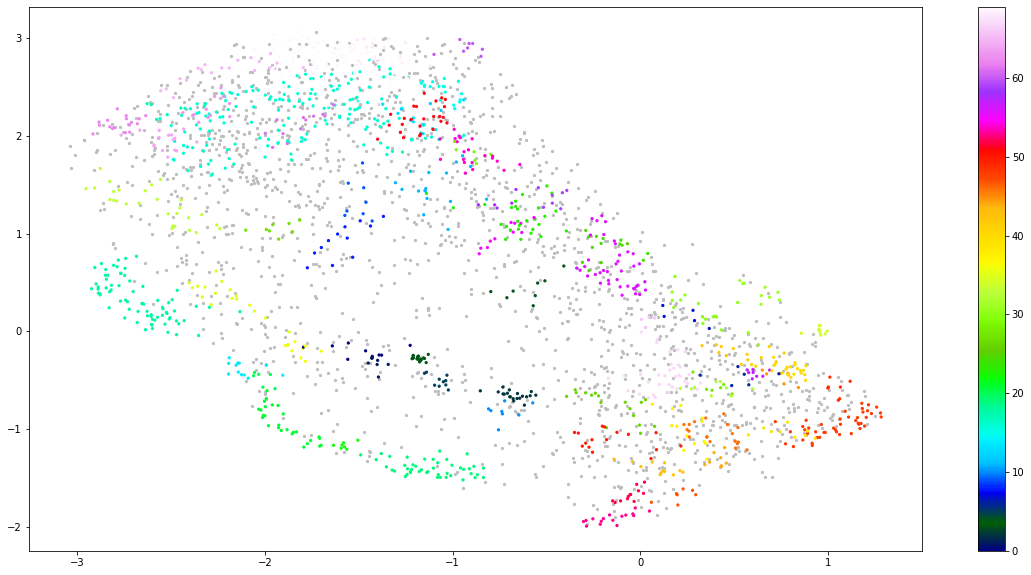

In [14]:
import matplotlib.pyplot as plt

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=5)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=5, cmap='gist_ncar')
plt.colorbar()

In [15]:
print(clustered)

             x  ...                                   dreams_shortened
11    0.271679  ...                                  dreamed full moon
16   -1.740898  ...  RCa already girlfriend, girl beautiful curls. ...
18    0.426396  ...  Dream: witch camp. very bad powerful witch ano...
20    0.688558  ...  dreamed weird class start BAn (Harry Potter). ...
22    0.596027  ...  dreamed party electrical congress mother went,...
...        ...  ...                                                ...
2801 -0.167821  ...  “In Bathroom” weird one. dream, I’m shower enc...
2802 -2.848741  ...                 boyfriend robbed three classmates.
2806 -0.717866  ...            dancing drag queens party laughing loud
2810 -1.563567  ...     speaking higher self - told 'time meaningless'
2814 -1.170503  ...                                           timeloop

[1238 rows x 6 columns]


Visualize the same as above in 3D in plotly

In [16]:
#!pip install plotly
import plotly.express as px

fig_2d = px.scatter(
    clustered, x=clustered.x, y=clustered.y,
    color=clustered.labels, color_continuous_scale='mygbm', labels={'color': 'Dream Topics'}, hover_data=['dreams']
)
fig_3d = px.scatter_3d(
    clustered, x=clustered.x, y=clustered.y, z=clustered.z,
    color=clustered.labels, color_continuous_scale='mygbm', labels={'color': 'Dream Topics'}, hover_data=['dreams']
)
fig_3d.update_traces(marker_size=2)

fig_2d.show()
fig_3d.show()

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


procedure bool is_inside:
    radius = distance(a,b)/2
    center_pt = (a+b)/2    
    vec1 = b - center_pt
    vec2 = p - center_pt
    prod = cross_product(vec1,vec2) 
    if orientation == 'left-of'
        return prod.z >= 0 && distance(center_pt,p) <= radius
    else
        return prod.z <= 0 && distance(center_pt,p) <= radius

In [62]:
import numpy as np

clustered = clustered.reset_index(drop=True)

def vectorAngle(potentialNode, previousNode, goal):
  # Parameters
  # previousNode: The previous dream node and origin of the search hemisphere.
  # potentialNode: One of the nodes that are checked for being inside above hemisphere.
  # goal: The constant, final dream node that the search hemisphere is orientated towards.
  # returns: Angle in degrees. If the angle is bigger than 90, the potential node is outside of the above hemisphere.
  ba = potentialNode - previousNode
  bc = goal - previousNode
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
  angle = np.arccos(cosine_angle)
  return np.degrees(angle)

def pointsInSphereSG(startDream, endDream, df):
  # returns: List of all points inside the sphere between start and end goal node.
  S = np.array([startDream.x, startDream.y, startDream.z])
  G = np.array([endDream.x, endDream.y, endDream.z])
  midPoint = np.array([(S[0]+ G[0])/2, (S[1] + G[1])/2, (S[2] + G[2])/2]) # Calculate the middle coordinate between S and G.
  radius = np.linalg.norm(S - G) / 2 # Calculate half distance between S and G.
  setOfPointsSG = []
  for i in range(len(df.index)):
    dream = df.iloc[i]
    distance = np.linalg.norm(midPoint - np.array([dream.x, dream.y, dream.z])) / 2
    if distance <= radius:
      setOfPointsSG.append(i)
  return setOfPointsSG

def bestNeighborNode(points, df):
  # returns: Next node with the smallest distance and best angle.
  bestDistance = None
  bestAngle = None
  nextNodeIndex = None
  previousNode = df.iloc[path[len(path) - 2]]
  goalNode = df.iloc[path[len(path) - 1]]
  S = np.array([previousNode.x, previousNode.y, previousNode.z])
  G = np.array([goalNode.x, goalNode.y, goalNode.z])
  for i in range(len(points)):
    potentialNode = df.iloc[points[i]]
    P = np.array([potentialNode.x, potentialNode.y, potentialNode.z])
    distance = np.linalg.norm(S - P)
    if distance <= maxDistance: # Check that the potential node is not too far away from the last node.
      angle = vectorAngle(P, S, G)
      if angle <= maxAngle: # Check that the angle to the next node is not too steep from the angle to the goal node.
        if bestDistance == None:
          nextNodeIndex = points[i]
          bestDistance = distance
          bestAngle = angle
        elif distance < bestDistance or distance == bestDistance and angle < bestAngle:
          nextNodeIndex = points[i]
          bestDistance = distance
          bestAngle = angle
  return nextNodeIndex

startDreamIndex = 1 # The start dream index.
endDreamIndex = 1000 # The end dream index.
path = [startDreamIndex, endDreamIndex] # The final path with all dream indices from start S to goal G.
maxDistance = 0.39 # The size of the hemisphere. Maximum distance between last dream node and potential next dream node.
maxAngle = 90.0 # The maximum angle between the previous dream node to the next dream node relative to the goal dream node.

# Main path finding algorithm
points = pointsInSphereSG(clustered.iloc[startDreamIndex], clustered.iloc[endDreamIndex], clustered) # Find all dreams inside the sphere with diameter of S->G.

while True:
  points.remove(path[len(path) - 2])
  nextNodeIndex = bestNeighborNode(points, clustered)
  if nextNodeIndex != None and nextNodeIndex != path[len(path) - 1]:
    path.insert(len(path) - 1, nextNodeIndex)
  else:
    break

print(path)
for i in range(len(path)):
  dream = clustered.iloc[path[i]]
  print([dream.x, dream.y, dream.z])

[1, 1101, 1114, 955, 1090, 803, 911, 1218, 812, 1117, 936, 1058, 1163, 1046, 919, 976, 1231, 1213, 951, 1145, 1129, 942, 1133, 1107, 1000]
[-1.7408984, 2.1996865, -4.749856]
[-1.6808774, 2.200834, -4.8095713]
[-1.3384728, 2.1083415, -4.895616]
[-1.4000635, 1.9646155, -4.9333243]
[-1.2617213, 1.9804561, -5.0267916]
[-1.1757116, 2.001157, -4.920175]
[-1.104198, 2.0646546, -4.959082]
[-1.101529, 2.1968873, -5.1195827]
[-1.0692437, 2.1972237, -5.171099]
[-1.1537282, 2.1718934, -5.292871]
[-1.2787482, 2.0346098, -5.2004757]
[-1.1703892, 2.0164773, -5.475439]
[-1.067058, 1.9671868, -5.463802]
[-0.9661843, 1.9969227, -5.5341434]
[-0.9605671, 1.9791312, -5.592384]
[-0.9763651, 1.938845, -5.597919]
[-0.9397635, 1.8364477, -5.488671]
[-0.9378976, 1.7261543, -5.5060873]
[-0.8965875, 1.7264541, -5.534968]
[-0.89359057, 1.6545053, -5.4800797]
[-0.7882509, 1.7712095, -5.4683304]
[-0.76288265, 1.7399763, -5.548789]
[-0.72666836, 1.6470903, -5.4922204]
[-0.64208037, 1.7063248, -5.4953485]
[-0.5438487,

In [1]:

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
 
#extract x and y coordinates from route list
x_coords = []
y_coords = []
z_coords = []
 
for i in range(len(path)):
  dream = clustered.iloc[path[i]]
  x = dream.x
  y = dream.y
  z = dream.z

  x_coords.append(x)
  y_coords.append(y)
  z_coords.append(z)

x_coords = np.array(x_coords)
y_coords = np.array(y_coords)
z_coords = np.array(z_coords)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter3D(goal[0],goal[1],goal[2], marker = "*", color = "red", s = 100)

for i in range(len(clustered.index)):
  d = clustered.iloc[i]
  ax.scatter3D(d.x,d.y,d.z,marker = "o", color = "grey", s = 1)


ax.plot3D(x_coords, y_coords, z_coords, color = "red")
plt.show()

NameError: ignored

# **Path Finding between Dreams**

In [ ]:
print(clustered)
a = []
for i in range(len(clustered.x.values)):
  a.insert(i, (clustered.x.values[i] * 1000, clustered.y.values[i] * 1000, clustered.z.values[i] * 1000))

NDIM = 3 # number of dimensions
# read points into array
a = np.array(a)
a = a.astype(int)
print(a.size / NDIM, NDIM)
a.shape = int(a.size / NDIM), NDIM

point = a[50] # choose random point
print('point:', point)
d = ((a-point)**2).sum(axis=1)  # compute distances
ndx = d.argsort() # indirect sort 

# print 10 nearest points to the chosen one
print(ndx)
for i in range(5):
  print(a[ndx[i]])

             x  ...                                   dreams_shortened
2    -1.934515  ...  dreamed Valentine's wrapping gifts Store. RCa ...
14   -1.493824  ...                                        dreamed Ake
16   -4.268902  ...  RCa already girlfriend, girl beautiful curls. ...
17   -5.389295  ...  University, style San Martin school, late, tho...
18   -1.817737  ...  Dream: witch camp. very bad powerful witch ano...
...        ...  ...                                                ...
2812 -2.439715  ...  may sound bit deep, yet memorable dream hearin...
2814 -2.812425  ...                                           timeloop
2816 -1.963800  ...  dreamt spaceship. aliens. Elon Musk giving tou...
2817 -4.401922  ...  reason cannot quite remember, across street ne...
2818 -4.125180  ...                     head full blood chasing school

[1408 rows x 6 columns]


NameError: ignored

In [ ]:
start_dream_index = 5
end_dream_index = 20

start = [clustered.x.values[start_dream_index], clustered.y.values[start_dream_index], clustered.z.values[start_dream_index]]
end = [clustered.x.values[end_dream_index], clustered.y.values[end_dream_index], clustered.z.values[end_dream_index]]

euclidean_distance = np.linalg.norm(start-end)


distance = math.sqrt(sum([(a - b) ** 2 for a, b in zip(x, y)]))

In [ ]:
start_dream_index = 0
end_dream_index = 100

start = [clustered[start_dream_index].x, clustered[start_dream_index].y, clustered[start_dream_index].z]
end = [clustered[end_dream_index].x, clustered[end_dream_index].y, clustered[end_dream_index].z]

In [ ]:
!pip install dijkstra3d

In [ ]:
import numpy as np
import time
import dijkstra3d

field = []
for i in range(len(clustered.x.values)):
  field[i]
field = np.array((clustered.x.values, clustered.y.values, clustered.z.values))
print(field)
source = (0,0,0)
target = (511,511,511)

path = dijkstra3d.dijkstra(field, source, target) # black line
path = dijkstra3d.dijkstra(field, source, target, bidirectional=True) # blue line
path = dijkstra3d.dijkstra(field, source, target, compass=True) # red line

In [ ]:
print(np.min(clustered.z))

In [ ]:
##############################################################################
# import packages
##############################################################################
 
import numpy as np
import heapq
import pandas as pd
from collections import OrderedDict
 
##############################################################################
# coordinate pairs
##############################################################################
 
x1 = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3]
y1 = [1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3]
z1 = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3]
x2 = [1,1,2,1,2,2,1,1,1,2,2,1,1,2,2,2,1,1,2,1,2,2,1,1,2,3,3,1,1,2,3,3,1,1,1,2,2,3,3,3,1,1,1,2,2,3,3,3,1,1,2,3,3,1,1,2,3,3,2,3,3,2,2,3,2,2,3,3,3,2,2,2,3,3,2,3,3,2,2,3,1,1,2,2,1,1,2,2,1,2,1,1,1,2,2,2,1,1,1,2,2,2,1,1,2,2,1,1,2,2,1,1,2,2,1,2,1,1,2,2,3,3,1,1,2,2,3,3,1,1,3,3,1,1,2,2,3,3,1,1,2,2,3,3,1,1,3,3,2,2,3,3,2,2,3,3,2,3,2,2,2,3,3,3,2,2,2,3,3,3,2,2,3,3,2,2,3,3,2,2,3,3,2,3,1,1,2,1,2,2,1,1,1,2,2,1,1,2,2,2,1,1,2,1,2,2,1,1,2,3,3,1,1,2,3,3,1,1,1,2,2,3,3,3,1,1,1,2,2,3,3,3,1,1,2,3,3,1,1,2,3,3,2,3,3,2,2,3,2,2,3,3,3,2,2,2,3,3,2,3,3,2,2,3]
y2 = [1,2,1,2,1,2,1,2,3,1,3,1,3,1,2,3,2,3,3,2,2,3,1,2,1,1,2,1,2,2,1,2,1,2,3,1,3,1,2,3,1,2,3,1,3,1,2,3,2,3,3,2,3,2,3,2,2,3,1,1,2,1,2,2,1,3,1,2,3,1,2,3,1,3,3,2,3,2,3,2,1,2,1,2,1,2,1,2,2,1,1,2,3,1,2,3,1,2,3,1,2,3,1,3,1,3,2,3,2,3,2,3,2,3,2,3,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,1,2,1,2,1,2,1,2,1,2,1,2,3,1,2,3,1,2,3,1,2,3,1,3,1,3,2,3,2,3,2,3,2,3,3,2,1,2,1,2,1,2,1,2,3,1,3,1,3,1,2,3,2,3,3,2,2,3,1,2,1,1,2,1,2,2,1,2,1,2,3,1,3,1,2,3,1,2,3,1,3,1,2,3,2,3,3,2,3,2,3,2,2,3,1,1,2,1,2,2,1,3,1,2,3,1,2,3,1,3,3,2,3,2,3,2]
z2 = [2,2,2,1,1,1,2,2,2,2,2,1,1,1,1,1,2,2,2,1,1,1,2,2,2,2,2,1,1,1,1,1,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,2,2,2,2,2,1,1,1,1,1,2,2,2,1,1,1,2,2,2,2,2,1,1,1,1,1,2,2,2,1,1,1,3,3,3,3,1,1,1,1,2,2,3,3,3,3,3,3,1,1,1,1,1,1,2,2,2,2,3,3,3,3,1,1,1,1,2,2,3,3,3,3,3,3,1,1,1,1,1,1,2,2,2,2,3,3,3,3,3,3,1,1,1,1,1,1,2,2,2,2,3,3,3,3,1,1,1,1,2,2,3,3,3,3,3,3,1,1,1,1,1,1,2,2,2,2,3,3,3,3,1,1,1,1,2,2,2,2,2,3,3,3,2,2,2,2,2,3,3,3,3,3,2,2,2,3,3,3,2,2,2,2,2,3,3,3,3,3,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,2,2,2,2,2,3,3,3,3,3,2,2,2,3,3,3,2,2,2,2,2,3,3,3,3,3,2,2,2,3,3,3]

print(len(x1))
print(clustered.x.values)

# x1 = clustered.x.values
# y1 = clustered.y.values
# z1 = clustered.z.values
# x2 = clustered.x.values
# y2 = clustered.y.values
# z2 = clustered.z.values


coord_pairs = pd.DataFrame( OrderedDict((('x1', pd.Series(x1)), ('y1', pd.Series(y1)), ('z1', pd.Series(z1)), ('x2', pd.Series(x2)), ('y2', pd.Series(y2)), ('z2', pd.Series(z2)))))
coord_pairs = coord_pairs.sort_values(['x1', 'y1', 'z1'], ascending=[True,True,True])
print(coord_pairs)
 
##############################################################################
# specify start and goal positions
##############################################################################
start = tuple([x1[0], y1[0], z1[0]])
goal = tuple([x1[6], y1[6], z1[6]])
print(start, goal)
 
##############################################################################
# a* path finding functions
##############################################################################
 
def available_neighbours(current_x,current_y,current_z):
  return list(zip(coord_pairs.loc[(coord_pairs.x1 == current_x) & (coord_pairs.y1 == current_y) & (coord_pairs.z1 == current_z)][["x2"]].x2,
coord_pairs.loc[(coord_pairs.x1 == current_x) & (coord_pairs.y1 == current_y) & (coord_pairs.z1 == current_z)][["y2"]].y2,
coord_pairs.loc[(coord_pairs.x1 == current_x) & (coord_pairs.y1 == current_y) & (coord_pairs.z1 == current_z)][["z2"]].z2))
 
def heuristic(a, b):
  return np.sqrt((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2 + (b[2] - a[2]) ** 2)
 
def astar(start, goal): 
  close_set = set()
  came_from = {}
  gscore = {start:0}
  fscore = {start:heuristic(start, goal)}
  oheap = []

  heapq.heappush(oheap, (fscore[start], start))
  while oheap:
      current = heapq.heappop(oheap)[1]
      neighbours = available_neighbours(current[0],current[1],current[2])
      if current == goal:
        data = []
        while current in came_from:
          data.append(current)
          current = came_from[current]
        return data

      close_set.add(current)
      for x, y, z in neighbours:
        neighbour = x, y, z
        tentative_g_score = gscore[current] + heuristic(current, neighbour)
        if neighbour in close_set and tentative_g_score >= gscore.get(neighbour, 0):
          continue

        if tentative_g_score < gscore.get(neighbour, 0) or neighbour not in [i[1]for i in oheap]:
          came_from[neighbour] = current
          gscore[neighbour] = tentative_g_score
          fscore[neighbour] = tentative_g_score + heuristic(neighbour, goal)
          heapq.heappush(oheap, (fscore[neighbour], neighbour))
  return False
 
##############################################################################
# calculate route
##############################################################################
 
route = astar(start, goal)
print("Route RAW: ", route)
route = route + [start]
route = route[::-1]
print("Route: ", route)
 
##############################################################################
# visualise the path
##############################################################################
 
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
 
#extract x and y coordinates from route list
x_coords = []
y_coords = []
z_coords = []
 
for i in (range(0,len(route))):
  x = route[i][0]
  y = route[i][1]
  z = route[i][2]

  x_coords.append(x)
  y_coords.append(y)
  z_coords.append(z)

x_coords = np.array(x_coords)
y_coords = np.array(y_coords)
z_coords = np.array(z_coords)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(goal[0],goal[1],goal[2], marker = "*", color = "red", s = 100)

ax.scatter3D(1,1,1,marker = "o", color = "black", s = 100)
ax.scatter3D(1,2,1,marker = "o", color = "black", s = 100)
ax.scatter3D(1,3,1,marker = "o", color = "black", s = 100)
ax.scatter3D(2,1,1,marker = "o", color = "black", s = 100)
ax.scatter3D(2,2,1,marker = "o", color = "black", s = 100)
ax.scatter3D(2,3,1,marker = "o", color = "black", s = 100)
ax.scatter3D(3,1,1,marker = "o", color = "black", s = 100)
ax.scatter3D(3,2,1,marker = "o", color = "black", s = 100)
ax.scatter3D(3,3,1,marker = "o", color = "black", s = 100)
ax.scatter3D(1,1,2,marker = "o", color = "black", s = 100)
ax.scatter3D(1,2,2,marker = "o", color = "black", s = 100)
ax.scatter3D(1,3,2,marker = "o", color = "black", s = 100)
ax.scatter3D(2,1,2,marker = "o", color = "black", s = 100)
ax.scatter3D(2,2,2,marker = "x", color = "black", s = 100)
ax.scatter3D(2,3,2,marker = "o", color = "black", s = 100)
ax.scatter3D(3,1,2,marker = "o", color = "black", s = 100)
ax.scatter3D(3,2,2,marker = "o", color = "black", s = 100)
ax.scatter3D(3,3,2,marker = "o", color = "black", s = 100)
ax.scatter3D(1,1,3,marker = "o", color = "black", s = 100)
ax.scatter3D(1,2,3,marker = "o", color = "black", s = 100)
ax.scatter3D(1,3,3,marker = "o", color = "black", s = 100)
ax.scatter3D(2,1,3,marker = "o", color = "black", s = 100)
ax.scatter3D(2,2,3,marker = "o", color = "black", s = 100)
ax.scatter3D(2,3,3,marker = "o", color = "black", s = 100)
ax.scatter3D(3,1,3,marker = "o", color = "black", s = 100)
ax.scatter3D(3,2,3,marker = "o", color = "black", s = 100)
#ax.scatter3D(3,3,3,marker = "o", color = "black", s = 100)

ax.plot3D(x_coords, y_coords, z_coords, color = "pink")
plt.show()

# **Topic Modeling**

In this example, we will go through the main components of BERTopic and the steps necessary to create a strong topic model. 




## Training

We start by instantiating BERTopic. We set language to `english` since our documents are in the English language. If you would like to use a multi-lingual model, please use `language="multilingual"` instead. 

We will also calculate the topic probabilities. However, this can slow down BERTopic significantly at large amounts of data (>100_000 documents). It is advised to turn this off if you want to speed up the model. 


In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

**NOTE**: Use `language="multilingual"` to select a model that support 50+ languages.

## Extracting Topics
After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents. 

In [ ]:
freq = topic_model.get_topic_info(); freq.head(500)

-1 refers to all outliers and should typically be ignored. Next, let's take a look at a frequent topic that were generated:

In [ ]:
topic_model.get_topic(1)  # Select the most frequent topic

**NOTE**: BERTopic is stocastich which mmeans that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

# **Visualization**
There are several visualization options available in BERTopic, namely the visualization of topics, probabilities and topics over time. Topic modeling is, to a certain extent, quite subjective. Visualizations help understand the topics that were created. 

## Visualize Topics
After having trained our `BERTopic` model, we can iteratively go through perhaps a hundred topic to get a good 
understanding of the topics that were extract. However, that takes quite some time and lacks a global representation. 
Instead, we can visualize the topics that were generated in a way very similar to 
[LDAvis](https://github.com/cpsievert/LDAvis):

In [ ]:
topic_model.visualize_topics()

## Visualize Topic Probabilities

The variable `probabilities` that is returned from `transform()` or `fit_transform()` can 
be used to understand how confident BERTopic is that certain topics can be found in a document. 

To visualize the distributions, we simply call:

In [ ]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)

## Visualize Topic Hierarchy

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we can use scipy.cluster.hierarchy to create clusters and visualize how they relate to one another. This might help selecting an appropriate nr_topics when reducing the number of topics that you have created.

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

## Visualize Terms

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [ ]:
topic_model.visualize_barchart(top_n_topics=5)

## Visualize Topic Similarity
Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [ ]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

## Visualize Term Score Decline
Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, the select the best number of words in a topic.


In [ ]:
topic_model.visualize_term_rank()

# **Topic Representation**
After having created the topic model, you might not be satisfied with some of the parameters you have chosen. Fortunately, BERTopic allows you to update the topics after they have been created. 

This allows for fine-tuning the model to your specifications and wishes. 

## Update Topics
When you have trained a model and viewed the topics and the words that represent them,
you might not be satisfied with the representation. Perhaps you forgot to remove
stopwords or you want to try out a different `n_gram_range`. We can use the function `update_topics` to update 
the topic representation with new parameters for `c-TF-IDF`: 


In [ ]:
topic_model.update_topics(docs, topics, n_gram_range=(1, 2))

In [ ]:
topic_model.get_topic(0)   # We select topic that we viewed before

## Topic Reduction
We can also reduce the number of topics after having trained a BERTopic model. The advantage of doing so, 
is that you can decide the number of topics after knowing how many are actually created. It is difficult to 
predict before training your model how many topics that are in your documents and how many will be extracted. 
Instead, we can decide afterwards how many topics seems realistic:





In [ ]:
new_topics, new_probs = topic_model.reduce_topics(docs, topics, probs, nr_topics=60)

# **Search Topics**
After having trained our model, we can use `find_topics` to search for topics that are similar 
to an input search_term. Here, we are going to be searching for topics that closely relate the 
search term "vehicle". Then, we extract the most similar topic and check the results: 

In [ ]:
similar_topics, similarity = topic_model.find_topics("nightmare", top_n=5); similar_topics

In [ ]:
topic_model.get_topic(71)

# **Model serialization**
The model and its internal settings can easily be saved. Note that the documents and embeddings will not be saved. However, UMAP and HDBSCAN will be saved. 

In [ ]:
# Save model
topic_model.save("my_model")	

In [ ]:
# Load model
my_model = BERTopic.load("my_model")	

# **Embedding Models**
The parameter `embedding_model` takes in a string pointing to a sentence-transformers model, a SentenceTransformer, or a Flair DocumentEmbedding model.

## Sentence-Transformers
You can select any model from sentence-transformers here and pass it through BERTopic with embedding_model:



In [ ]:
topic_model = BERTopic(embedding_model="xlm-r-bert-base-nli-stsb-mean-tokens")

Or select a SentenceTransformer model with your own parameters:


In [ ]:
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("distilbert-base-nli-mean-tokens", device="cpu")
topic_model = BERTopic(embedding_model=sentence_model, verbose=True)

Click [here](https://www.sbert.net/docs/pretrained_models.html) for a list of supported sentence transformers models.  
